# Hands-on 03: Tabular data and NNs: Classifying particle jets

In [26]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import numpy as np
import tensorflow as tf

%matplotlib inline
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## Fetch the jet tagging dataset from Open ML

In [27]:
data = fetch_openml("hls4ml_lhc_jets_hlf", parser="auto")
X, y = data["data"], data["target"]

### Lets see what the jet variables look like

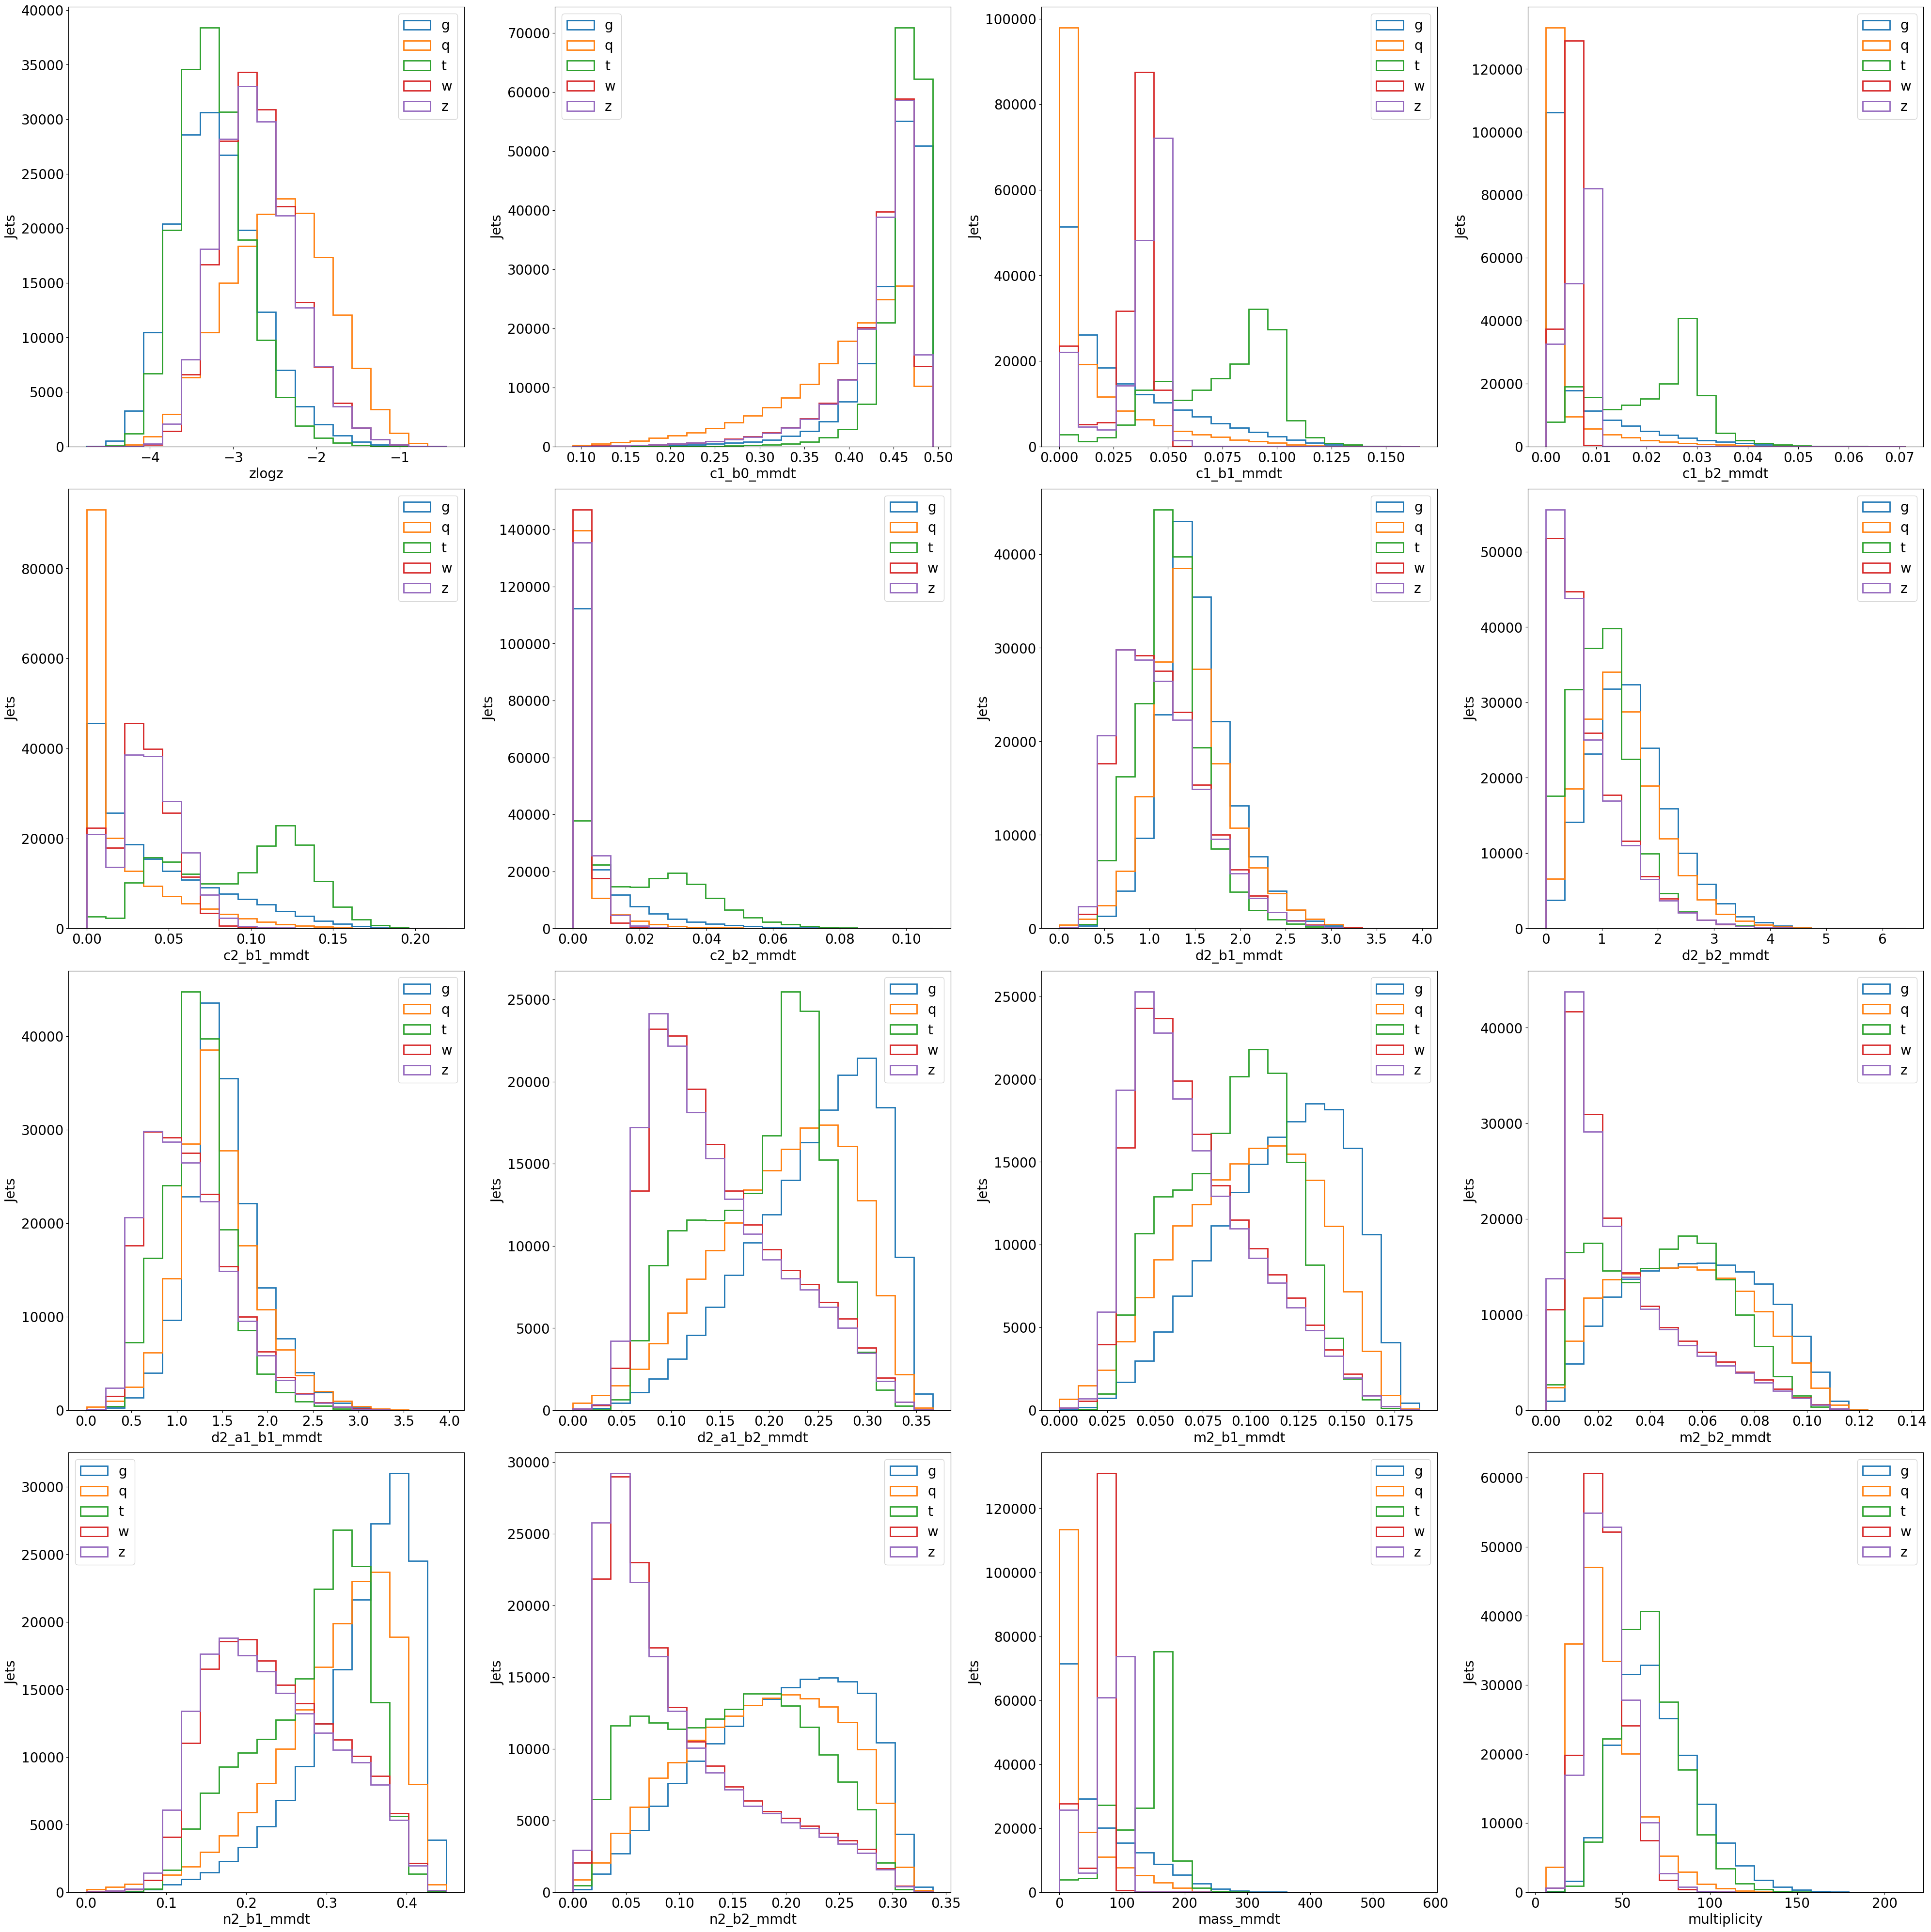

In [29]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 4, figsize=(40, 40))

for ix, ax in enumerate(axs.reshape(-1)):
    feat = data["feature_names"][ix]
    bins = np.linspace(np.min(X[:][feat]), np.max(X[:][feat]), 20)
    for c in y.dtype.categories:
        ax.hist(X[y == c][feat], bins=bins, histtype="step", label=c, lw=2)
    ax.set_xlabel(feat, fontsize=20)
    ax.set_ylabel("Jets", fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=20)
    ax.legend(fontsize=20, loc="best")
plt.tight_layout()
plt.show()

In [30]:
le = LabelEncoder()
y_onehot = le.fit_transform(y)
y_onehot = to_categorical(y_onehot, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
print(y[:5])
print(y_onehot[:5])

0    g
1    w
2    t
3    z
4    w
Name: class, dtype: category
Categories (5, object): ['g', 'q', 't', 'w', 'z']
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


## Now construct a simple neural network
We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

In [32]:
model = Sequential(name="sequential1")
model.add(Input(shape=(16,)))
model.add(Dense(64, name="fc1"))
model.add(Activation(activation="relu", name="relu1"))
model.add(Dense(32, name="fc2"))
model.add(Activation(activation="relu", name="relu2"))
model.add(Dense(32, name="fc3"))
model.add(Activation(activation="relu", name="relu3"))
model.add(Dense(5, name="fc4"))
model.add(Activation(activation="softmax", name="softmax"))
model.summary()

Model: "sequential1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc4 (Dense)                     │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,389 (17.14 KB)

 Trainable params: 4,389 (17.14 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model
We'll use SGD optimizer with categorical crossentropy loss.
The model isn't very complex, so this should just take a few minutes even on the CPU.

In [33]:
model.compile(optimizer="sgd", loss=["categorical_crossentropy"], metrics=["accuracy"])
history = model.fit(X_train_val, y_train_val, batch_size=1024, epochs=50, validation_split=0.25, shuffle=True, verbose=0)

In [34]:
def distribution_weights(model):
    for layer in model.layers:
        w = layer.get_weights()
        if w:
            arr = w[0]
            print(layer.name, np.min(arr), np.max(arr), np.mean(arr), np.std(arr))

In [35]:
distribution_weights(model)

fc1 -1.3474276 1.3272389 -0.00063446956 0.19662036
fc2 -0.31283274 0.32036585 -0.005109553 0.14243218
fc3 -0.6062201 0.59100384 -0.0036595727 0.18587713
fc4 -1.1284931 0.82731897 -0.03579145 0.32603812


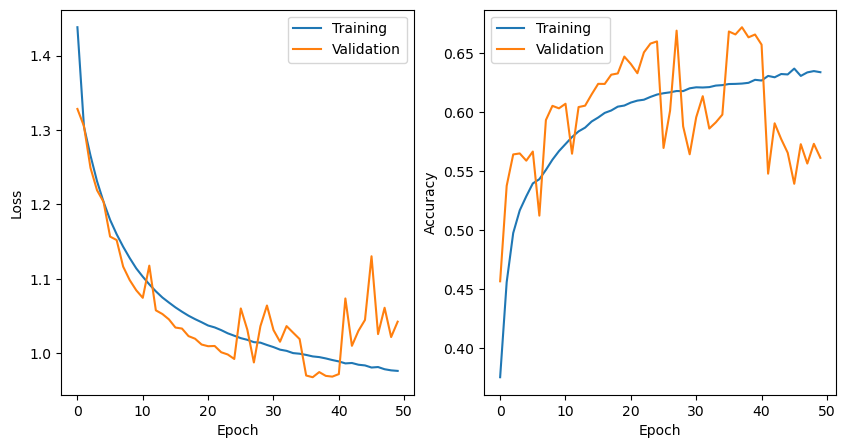

In [36]:
from plotting import plot_model_history

plot_model_history(history)

## Check performance
Check the accuracy and make a ROC curve

In [37]:
from plotting import make_roc, plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

y_keras = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}")

Accuracy: 0.5605963855421687


<Figure size 500x500 with 0 Axes>

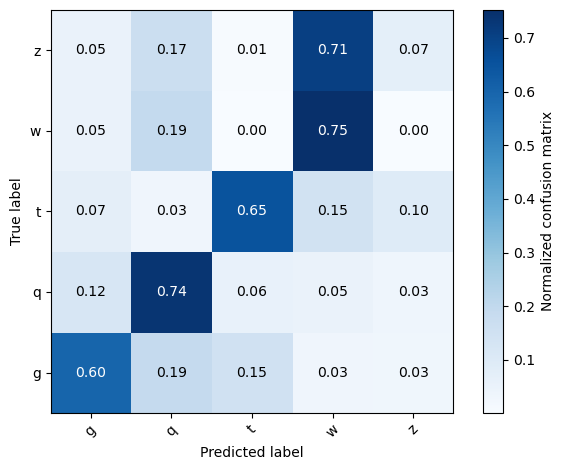

In [38]:
plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, y_keras, classes=le.classes_, normalize=True)

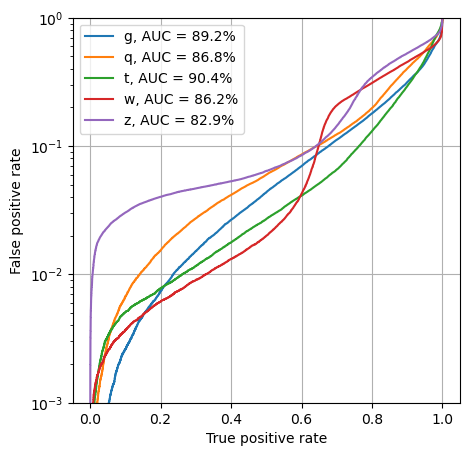

In [39]:
plt.figure(figsize=(5, 5))
make_roc(y_test, y_keras, le.classes_)

# Exercises

In [40]:
def run_model(name, 
              X_training_data, 
              y_training_data, 
              X_test_data, 
              y_test_data, 
              optimizer="sgd", 
              scaled=False, 
              regularization=False, 
              modelSummary=False):

    if scaled:
        scaler = StandardScaler()
        X_training_data = scaler.fit_transform(X_training_data)
        X_test_data = scaler.transform(X_test_data)

    model = Sequential(name=f"sequential1_{name}")
    model.add(Input(shape=(16,)))
    
    if regularization:
        model.add(Dense(64, name="fc1", kernel_regularizer=l1(0.01)))
    else:
        model.add(Dense(64, name="fc1"))
    model.add(Activation(activation="relu", name="relu1"))
    model.add(Dense(32, name="fc2"))
    model.add(Activation(activation="relu", name="relu2"))
    model.add(Dense(32, name="fc3"))
    model.add(Activation(activation="relu", name="relu3"))
    model.add(Dense(5, name="fc4"))
    model.add(Activation(activation="softmax", name="softmax"))

    if modelSummary:
        model.summary()

    model.compile(optimizer=optimizer, loss=["categorical_crossentropy"], metrics=["accuracy"])
    history = model.fit(X_training_data, y_training_data, batch_size=1024, epochs=50, validation_split=0.25, shuffle=True, verbose=0)

    plot_model_history(history)

    y_keras = model.predict(X_test_data, batch_size=1024, verbose=0)
    print(f"Accuracy: {accuracy_score(np.argmax(y_test_data, axis=1), np.argmax(y_keras, axis=1))}")

    distribution_weights(model)

    plt.figure(figsize=(5, 5))
    plot_confusion_matrix(y_test_data, y_keras, classes=le.classes_, normalize=True)

    plt.figure(figsize=(5, 5))
    make_roc(y_test_data, y_keras, le.classes_)

    return model

1. Apply a standard scaler to the inputs. How does the performance of the model change?

```python
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)
```

Accuracy: 0.7490060240963855
fc1 -0.9241199 0.81083953 -0.0036893745 0.19325085
fc2 -0.55273646 0.6438942 0.015476689 0.16474485
fc3 -0.71507347 0.71998227 0.010041023 0.21056752
fc4 -0.9602999 0.86939406 0.0074727335 0.38576978


<Sequential name=sequential1_scaled, built=True>

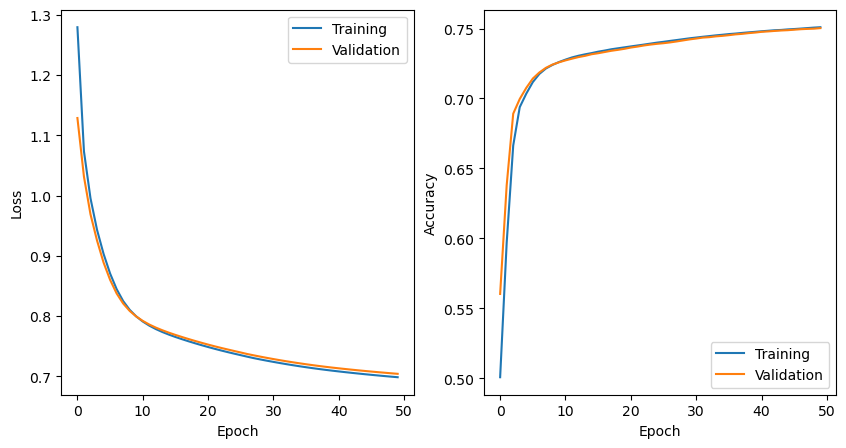

<Figure size 500x500 with 0 Axes>

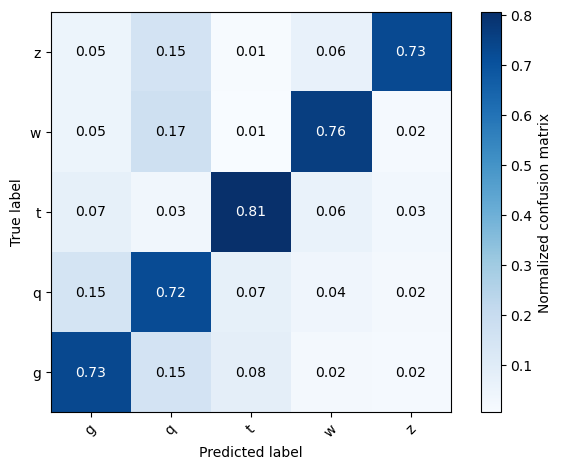

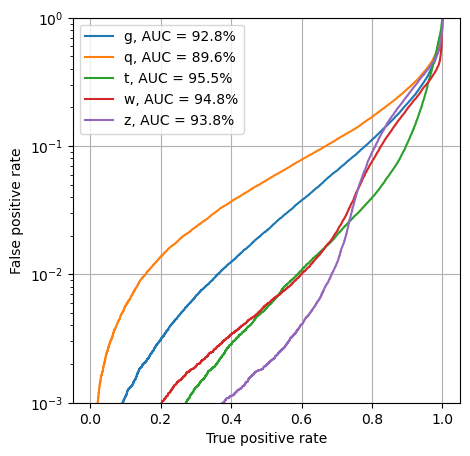

In [41]:
run_model("scaled", X_train_val, y_train_val, X_test, y_test, scaled=True)

With the scaling, the loss and accuracy curves are very smooooth. Also the accuracy went way up, overall very good effect.

2. Apply L1 regularization. How does the performance of the model change? How do the distribution of the weight values change?

```python
model.add(Dense(64, input_shape=(16,), name="fc1", kernel_regularizer=l1(0.01)))
```

Accuracy: 0.5503795180722891
fc1 -0.037136562 0.2775213 0.0007211752 0.013455774
fc2 -0.40801904 0.32105696 -0.002530575 0.14293677
fc3 -0.40351707 0.4430326 -0.0004476437 0.17798892
fc4 -1.9003155 0.9236936 0.015424743 0.38523453


<Sequential name=sequential1_L1, built=True>

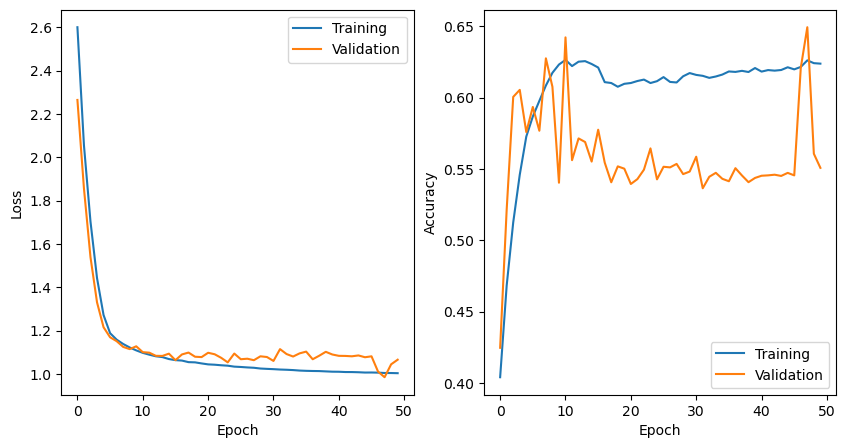

<Figure size 500x500 with 0 Axes>

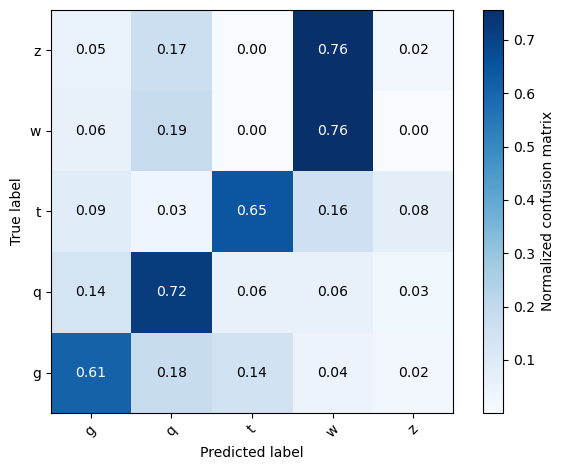

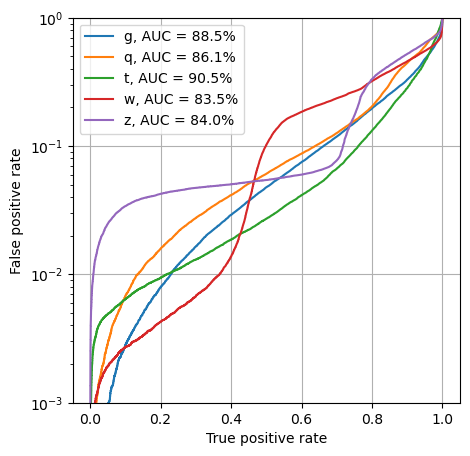

In [42]:
run_model("L1", X_train_val, y_train_val, X_test, y_test, regularization=True)

3. How do the loss curves change if we use a smaller learning rate (say `1e-5`) or a larger one (say `0.1`)?

Training with learning rate: 1e-05
Accuracy: 0.38946385542168677
fc1 -0.27354676 0.27967808 0.0021745854 0.15698375
fc2 -0.26609194 0.26074687 0.0022924799 0.14444862
fc3 -0.30595315 0.32179144 0.0022396243 0.17677936
fc4 -0.41876158 0.40217695 0.0111032175 0.2319876
fc1 0.27967808 0.0021745854 -0.27354676
fc2 0.26074687 0.0022924799 -0.26609194
fc3 0.32179144 0.0022396243 -0.30595315
fc4 0.40217695 0.0111032175 -0.41876158
Training with learning rate: 0.1
Accuracy: 0.42093373493975905
fc1 -108.28281 2.8743262 -0.42084625 4.4976287
fc2 -182.4237 21.965376 -0.506625 6.6133
fc3 -97.48913 3.8975592 -1.481139 7.310942
fc4 -47.401962 13.3342705 0.007679033 7.1337285
fc1 2.8743262 -0.42084625 -108.28281
fc2 21.965376 -0.506625 -182.4237
fc3 3.8975592 -1.481139 -97.48913
fc4 13.3342705 0.007679033 -47.401962


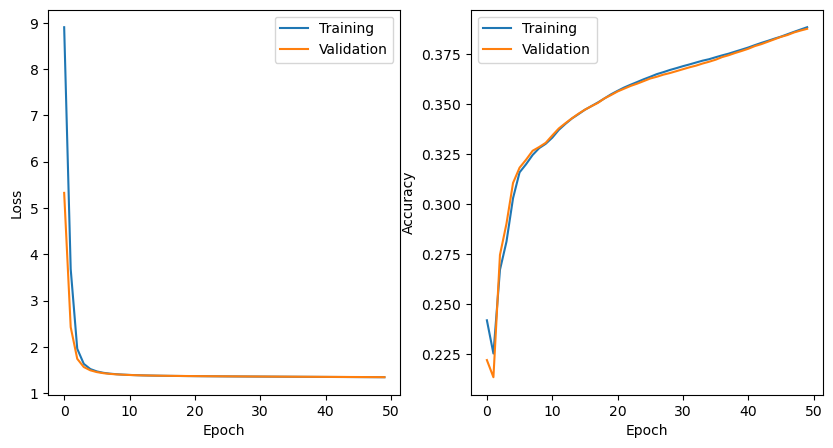

<Figure size 500x500 with 0 Axes>

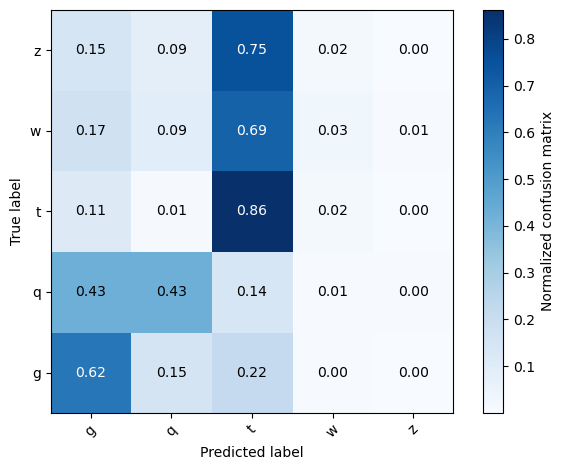

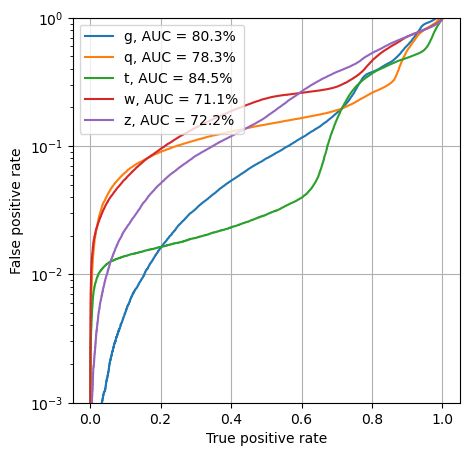

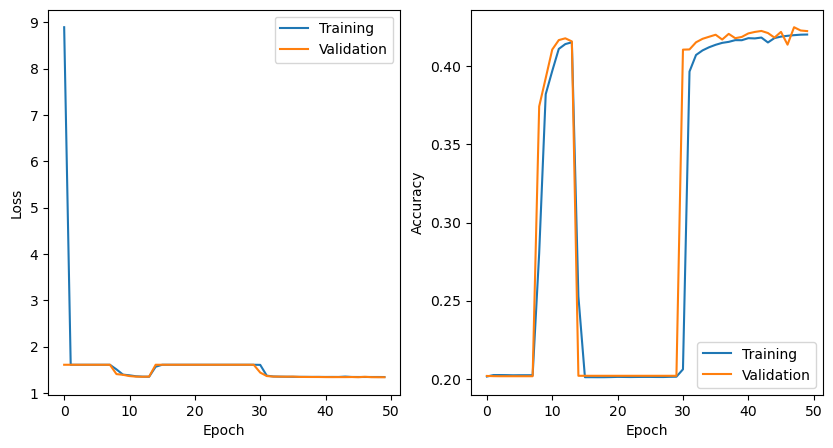

<Figure size 500x500 with 0 Axes>

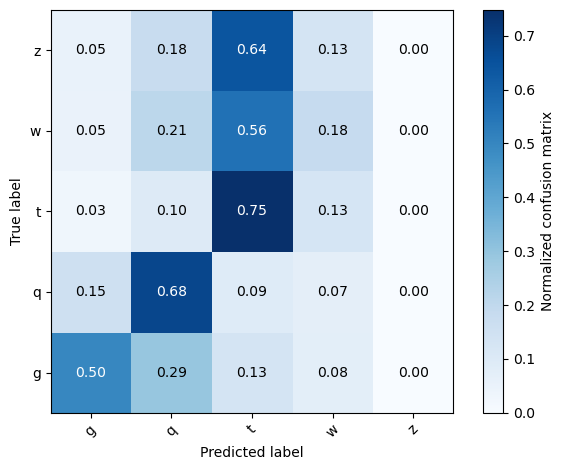

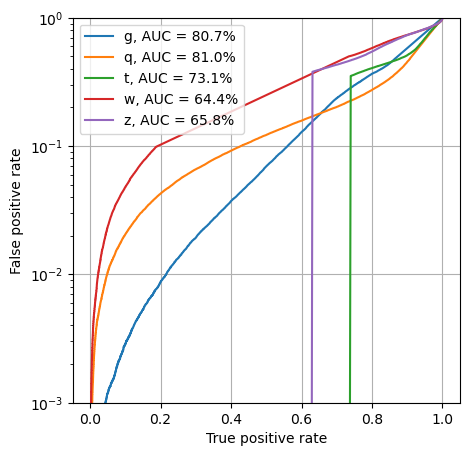

In [43]:
from tensorflow.keras.optimizers import SGD

learning_rates = [1e-5, 0.1]

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = run_model(f"lr_{lr}", X_train_val, y_train_val, X_test, y_test, optimizer=SGD(learning_rate=lr))
    for layer in model.layers:
        w = layer.get_weights()
        if w:
            arr = w[0]
            print(layer.name, np.max(arr), np.mean(arr), np.min(arr))


Both are quite shit. 1e-5 won't get anywhere, and with 0.1 the weights are exploding making w the answer to everything

4. How does the loss curve change and the performance of the model change if we use Adam as the optimizer instead of SGD?

Accuracy: 0.5682349397590362
fc1 -1.1520971 1.4392871 -0.0061056023 0.19438897
fc2 -0.33207324 0.37656862 -0.0015244302 0.14497511
fc3 -0.56719625 0.5158807 -0.016675873 0.18554924
fc4 -1.537774 0.8938649 -0.0076303976 0.34872583


<Sequential name=sequential1_sgd, built=True>

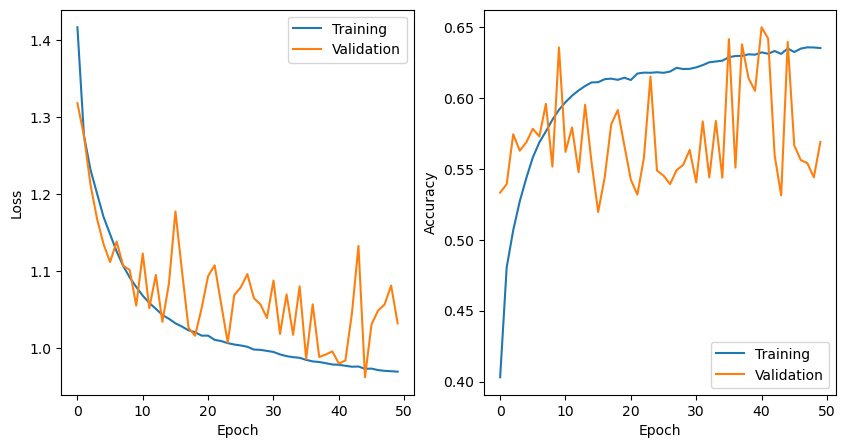

<Figure size 500x500 with 0 Axes>

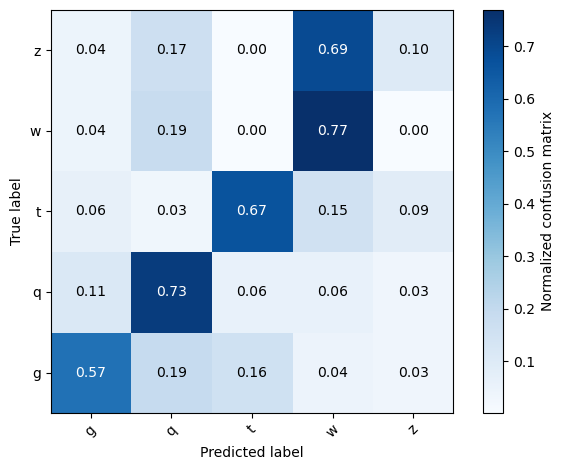

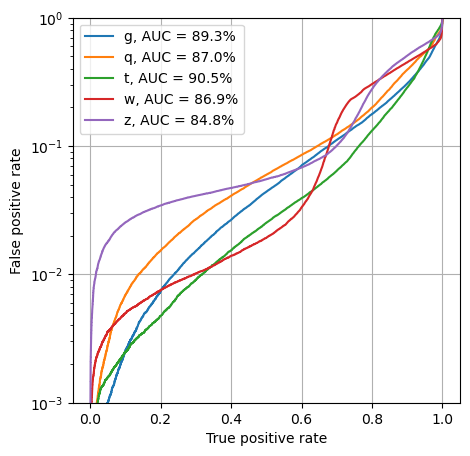

In [44]:
run_model(f"sgd", X_train_val, y_train_val, X_test, y_test)

Accuracy: 0.7385
fc1 -9.025112 6.7606854 -0.03254625 1.3984452
fc2 -1.4220619 1.1046972 -0.010155535 0.18870592
fc3 -2.4307265 1.0565083 -0.014015345 0.27929738
fc4 -1.8018765 1.2599952 0.014330661 0.40919074


<Sequential name=sequential1_adam, built=True>

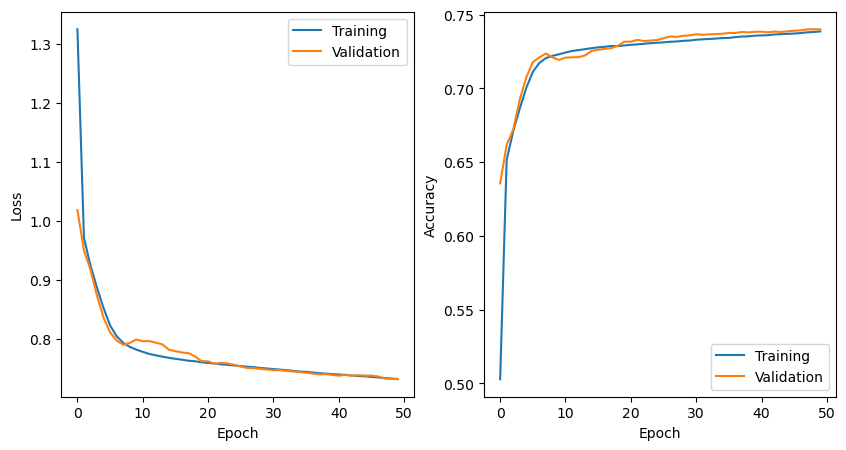

<Figure size 500x500 with 0 Axes>

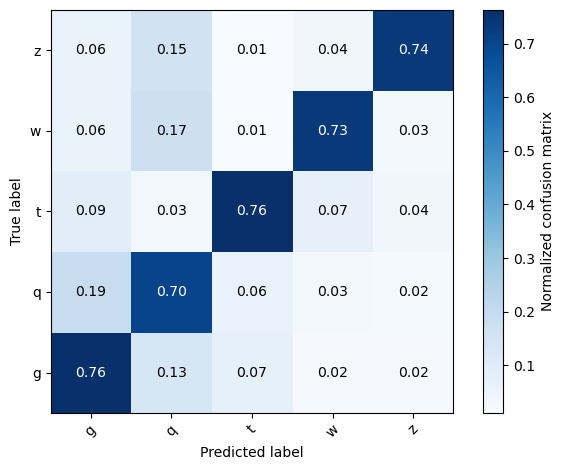

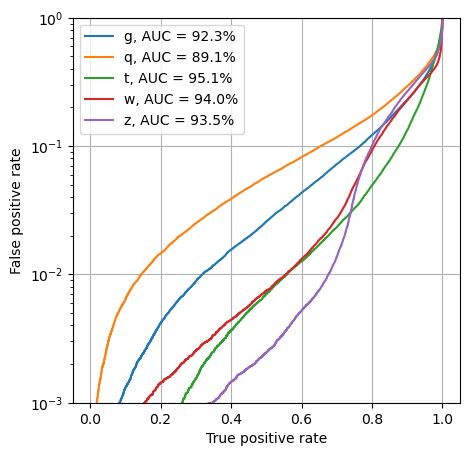

In [45]:
run_model(f"adam", X_train_val, y_train_val, X_test, y_test, optimizer="adam")

Very smooth, this is because Adam can change the learning rate based on the gradient. So we dont get the jaggedy curve like before and it reaches a pretty nice accuracy.